# Basic Libraries

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

import math
import random

from qiskit.providers.aer.noise import NoiseModel
from qiskit.aqua import QuantumInstance
from qiskit.providers.aer.noise import thermal_relaxation_error, ReadoutError, depolarizing_error

# provider = IBMQ.get_provider(hub='ibm-q')
# machine = provider.get_backend('ibmq_valencia')
from qiskit.test.mock import FakeBogota
machine = FakeBogota()
machine_noise_model = NoiseModel.from_backend(machine)
simulator = Aer.get_backend('qasm_simulator')


basis_gates = machine_noise_model.basis_gates

C:\Users\isido\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


# Important Functions

In [2]:
#Local Hamiltonian Function
from VQEHamiltonian_funcs import Hammifier, circs

#Readout Mit Functions
#from ReadoutMit import prepare_circuit, modify_counts, symmetry

# Expectation Value/Running Functions
from Result_ReadoutMit_funcs import binaryToDecimal, dictToList, sampleExpecVal, countToEig, expecValForSamples, addDicts, prepare_circuit_normal, prepare_circuit, modify_counts, symmetry, evaluator

# Restricted Range Info

In [3]:
'''------------Interatomic Distance = 0.74--------------
HF energy: -1.831863646477506
# of electrons: 2
# of spin orbitals: 4
Number of qubits are : 2
[ 0.00172129 -0.00182397 -0.11217598]
VQE Result: -1.1011690791894007 Exact Energy: -1.1372838344885012
All energies have been calculated'''

'------------Interatomic Distance = 0.74--------------\nHF energy: -1.831863646477506\n# of electrons: 2\n# of spin orbitals: 4\nNumber of qubits are : 2\n[ 0.00172129 -0.00182397 -0.11217598]\nVQE Result: -1.1011690791894007 Exact Energy: -1.1372838344885012\nAll energies have been calculated'

# Noise Model

In [4]:
'''

def generateDepolarizingError(machine, gate, qubits)

def generateRelaxationError(machine, gate, qubits, t1, t2, amp = 1, custom_t = False):
    """
    Return a relaxation error
    """

def generateNoiseModel(machine, coherent = True, incoherent = False, readout = False, custom_t = False, t1 = None, t2 = None, reverse = False):
    """
    Returns a realistic copy of london noise model with custom t1, t2 times
    """

'''

from NoiseModel import generateDepolarizingError, generateRelaxationError, generateNoiseModel

In [5]:
 noise_model = generateNoiseModel(machine, coherent = False, incoherent = False, readout= True)

Original: 0.024 0.10799999999999998
Reverse: 0.024 0.10799999999999998
Original: 0.004 0.039000000000000035
Reverse: 0.004 0.039000000000000035
Original: 0.009000000000000008 0.026
Reverse: 0.009000000000000008 0.026
Original: 0.005 0.03400000000000003
Reverse: 0.005 0.03400000000000003
Original: 0.019 0.135
Reverse: 0.019 0.135


# Variational Form
For Hydrogen

In [6]:
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

initial_state = HartreeFock(
4,
2,
'parity'
) 
var_form = UCCSD(
            num_orbitals=4,
            num_particles=2,
            initial_state=initial_state,
            qubit_mapping='parity'
        )

# Running Circuits for different Param

In [7]:
counter = 0

def EnergyFinder(param):
    '''
    Input: param (1D array) for which to compute energy on VQE circ of H2
    Output: energy
    '''
    
    Hamiltonian = """II\nIZ\nZI\nZZ\nXX"""
    Hamiltonian_weights = [-1.053, 0.395, -0.395, -0.011, 0.181]
    backend = simulator
    global noise_model
    samples = 10000
    
    
    
    circ = var_form.construct_circuit(param).decompose()
    circuits = Hammifier(circ, Hamiltonian)
    circs_nr = circs(circuits)
    circs_inr = circs(circuits)
    circs_r = circs(circuits)
    circs_ideal = circs(circuits)
    
    #print('no mit')
    noisy_r = evaluator(circs_r, samples, noise_model, Hamiltonian, Hamiltonian_weights, simulator, readout_mit = False)
    #print('mit')
    noisy_nr = evaluator(circs_nr, samples, noise_model, Hamiltonian, Hamiltonian_weights, simulator, readout_mit = True)
    noisy_inr = evaluator(circs_inr, samples, noise_model, Hamiltonian, Hamiltonian_weights, simulator, readout_mit = True, invert = True)
    #print('no mit')
    ideal = evaluator(circs_ideal, samples, None, Hamiltonian, Hamiltonian_weights, simulator, False)
    #print('done')
    return noisy_r, noisy_nr, noisy_inr, ideal

def main():
    '''
    Choose param and compute mean
    '''
    d = -math.pi
    u = math.pi
    
    energies = []
    diff_r = []
    diff_nr = []
    diff_inr = []
    params = []
    
    for i in range(1000):
        print(i)
    
        p1 = random.uniform(0.001, 0.002)
        p2 = random.uniform(-0.002, -0.001)
        p3 = random.uniform(-0.2, -0.1)


        noisy_r,noisy_nr, noisy_inr, ideal = EnergyFinder([p1,p2,p3])
        energies.append([[p1,p2,p3], ideal, noisy_r, noisy_nr, noisy_inr])
        diff_r.append(noisy_r-ideal)
        diff_nr.append(noisy_nr-ideal)
        diff_inr.append(noisy_inr-ideal)
        
        print('Noisy diff is ' + str(noisy_r-ideal))
        print('Mitigated diff is ' + str(noisy_nr-ideal))
        print('Inverted Mitigated diff is ' + str(noisy_inr-ideal))
        
    return energies, diff_r, diff_nr, diff_inr
energies, diff_r, diff_nr, diff_inr = main()

0
Noisy diff is 0.09457446289062488
Mitigated diff is 0.012783572704422097
Inverted Mitigated diff is -0.011633277112427454
1
Noisy diff is 0.09985449218749987
Mitigated diff is 0.0050851128472222396
Inverted Mitigated diff is -0.007295839533730364
2
Noisy diff is 0.09664111328125002
Mitigated diff is 0.005898856265262653
Inverted Mitigated diff is -0.016751204784798635
3
Noisy diff is 0.09818505859374993
Mitigated diff is 0.013207068516550402
Inverted Mitigated diff is -0.014282483998206752
4
Noisy diff is 0.10483032226562483
Mitigated diff is 0.013818551253014677
Inverted Mitigated diff is -0.013619933560363506
5
Noisy diff is 0.0900742187500001
Mitigated diff is 0.005110028018795454
Inverted Mitigated diff is -0.007102366771783997
6
Noisy diff is 0.11356494140624995
Mitigated diff is 0.01505515026423243
Inverted Mitigated diff is -0.0013109059018237001
7
Noisy diff is 0.098790283203125
Mitigated diff is 0.008636733805686303
Inverted Mitigated diff is -0.013395993022986108
8
Noisy di

Noisy diff is 0.10131494140624997
Mitigated diff is 0.008757478911686434
Inverted Mitigated diff is -0.013702683817918171
67
Noisy diff is 0.09512280273437512
Mitigated diff is 0.015645403776995748
Inverted Mitigated diff is -0.004680603549011675
68
Noisy diff is 0.09219848632812488
Mitigated diff is 0.007339935306461154
Inverted Mitigated diff is -0.014581178382634175
69
Noisy diff is 0.10733837890624998
Mitigated diff is 0.012018293018830173
Inverted Mitigated diff is -0.0017274945269574182
70
Noisy diff is 0.10139843749999977
Mitigated diff is 0.012512489864735743
Inverted Mitigated diff is -0.0009146163623703352
71
Noisy diff is 0.09716503906249996
Mitigated diff is 0.01515816091460609
Inverted Mitigated diff is -0.010959055202609758
72
Noisy diff is 0.10014111328125008
Mitigated diff is 0.02334032332684699
Inverted Mitigated diff is -0.016694850156269148
73
Noisy diff is 0.10661157226562512
Mitigated diff is 0.01681452652519777
Inverted Mitigated diff is -0.011320215082226692
74
N

Noisy diff is 0.09599511718749976
Mitigated diff is 0.014720983037145086
Inverted Mitigated diff is -0.002690982774820716
133
Noisy diff is 0.1006611328125
Mitigated diff is 0.008163518617056775
Inverted Mitigated diff is -0.007896861704918434
134
Noisy diff is 0.10225122070312487
Mitigated diff is 0.013936633792639652
Inverted Mitigated diff is -0.011823561567555929
135
Noisy diff is 0.10279663085937507
Mitigated diff is 0.0148892163771559
Inverted Mitigated diff is -0.01036841488047524
136
Noisy diff is 0.09660620117187513
Mitigated diff is 0.00981137039501312
Inverted Mitigated diff is -0.006091682108039453
137
Noisy diff is 0.10180712890624988
Mitigated diff is 0.015981974194425153
Inverted Mitigated diff is -0.009978709566258237
138
Noisy diff is 0.10221606445312503
Mitigated diff is 0.007758828058218592
Inverted Mitigated diff is -0.00960098307212176
139
Noisy diff is 0.09231323242187495
Mitigated diff is 0.009594509429372566
Inverted Mitigated diff is -0.0029920595571963915
140


Noisy diff is 0.09413989257812494
Mitigated diff is 0.0077788925375839035
Inverted Mitigated diff is -0.0090953443366526
199
Noisy diff is 0.10249853515624985
Mitigated diff is 0.013209721268860664
Inverted Mitigated diff is -0.0022896697215548656
200
Noisy diff is 0.099057861328125
Mitigated diff is 0.009952607114202427
Inverted Mitigated diff is -0.014042010609832678
201
Noisy diff is 0.09531909179687492
Mitigated diff is 0.00981736081032869
Inverted Mitigated diff is -0.005819957543560683
202
Noisy diff is 0.09849047851562487
Mitigated diff is 0.014050338398580609
Inverted Mitigated diff is -0.007700333152091066
203
Noisy diff is 0.10474511718750001
Mitigated diff is 0.009807676091270201
Inverted Mitigated diff is -0.009790693005280016
204
Noisy diff is 0.1026977539062498
Mitigated diff is 0.01022995295112894
Inverted Mitigated diff is -0.009818226722279721
205
Noisy diff is 0.09127246093749997
Mitigated diff is 0.012222376039758842
Inverted Mitigated diff is -0.0021851941678112663


Noisy diff is 0.10660156249999986
Mitigated diff is 0.014588971384775107
Inverted Mitigated diff is -0.0033841633081057587
265
Noisy diff is 0.09336181640624996
Mitigated diff is 0.019791034524286655
Inverted Mitigated diff is -0.008601883668631682
266
Noisy diff is 0.09672216796875
Mitigated diff is 0.00899400832999464
Inverted Mitigated diff is -0.009817224881238484
267
Noisy diff is 0.09148803710937514
Mitigated diff is 0.004837595450339904
Inverted Mitigated diff is -0.014519181106436685
268
Noisy diff is 0.09486254882812495
Mitigated diff is 0.010676777427216733
Inverted Mitigated diff is -0.016715324130741394
269
Noisy diff is 0.10466186523437493
Mitigated diff is 0.019145141750610772
Inverted Mitigated diff is -0.011679034073565298
270
Noisy diff is 0.09176025390624976
Mitigated diff is 0.010672348408075294
Inverted Mitigated diff is -0.0051711341121989385
271
Noisy diff is 0.0959140624999999
Mitigated diff is 0.009226021157661801
Inverted Mitigated diff is -0.01887043793879739


Noisy diff is 0.09360473632812494
Mitigated diff is 0.009139741085737452
Inverted Mitigated diff is -0.008957206411210006
331
Noisy diff is 0.10027954101562497
Mitigated diff is 0.011782500095390835
Inverted Mitigated diff is -0.0046412243653832785
332
Noisy diff is 0.10208886718749988
Mitigated diff is 0.015502862556280528
Inverted Mitigated diff is -0.004001166747748863
333
Noisy diff is 0.09700854492187494
Mitigated diff is 0.016819429718502033
Inverted Mitigated diff is -0.007391315092242889
334
Noisy diff is 0.10090405273437475
Mitigated diff is 0.01154928621281126
Inverted Mitigated diff is -0.001914236051492324
335
Noisy diff is 0.0982856445312501
Mitigated diff is 0.014208633396768366
Inverted Mitigated diff is -0.01393642154828667
336
Noisy diff is 0.09504028320312485
Mitigated diff is 0.014155288163442581
Inverted Mitigated diff is -0.009342933802919617
337
Noisy diff is 0.09286840820312514
Mitigated diff is 0.0013038018567803622
Inverted Mitigated diff is -0.0238708013178226

Noisy diff is 0.09528222656250018
Mitigated diff is 0.013321335863572203
Inverted Mitigated diff is -0.013221765479529024
397
Noisy diff is 0.10636669921874986
Mitigated diff is 0.021023749197427444
Inverted Mitigated diff is 0.001824579579647434
398
Noisy diff is 0.1019030761718751
Mitigated diff is 0.0243798555930117
Inverted Mitigated diff is -0.006095171882870565
399
Noisy diff is 0.09359301757812499
Mitigated diff is 0.0037475475641981504
Inverted Mitigated diff is -0.011396530579880215
400
Noisy diff is 0.09698364257812497
Mitigated diff is 0.014366381746508727
Inverted Mitigated diff is -0.005691493711366791
401
Noisy diff is 0.10010644531249979
Mitigated diff is 0.014455408534607361
Inverted Mitigated diff is -0.007889402210203178
402
Noisy diff is 0.10046630859375016
Mitigated diff is 0.021669391741071742
Inverted Mitigated diff is 0.0004122488839288785
403
Noisy diff is 0.09881591796875022
Mitigated diff is 0.017153418505322815
Inverted Mitigated diff is -0.00794434652120013


Noisy diff is 0.10134863281249995
Mitigated diff is 0.008202054119925029
Inverted Mitigated diff is -0.011223586905715788
463
Noisy diff is 0.1039814453125002
Mitigated diff is 0.01319151153750786
Inverted Mitigated diff is -0.005202871856875735
464
Noisy diff is 0.10516870117187493
Mitigated diff is 0.015235601932571008
Inverted Mitigated diff is -0.009935820407890539
465
Noisy diff is 0.09966650390624998
Mitigated diff is 0.006177054596878673
Inverted Mitigated diff is -0.007338207918383688
466
Noisy diff is 0.09541308593749998
Mitigated diff is 0.005562736688225156
Inverted Mitigated diff is -0.010560584435095999
467
Noisy diff is 0.10008959960937491
Mitigated diff is 0.010575715605352087
Inverted Mitigated diff is -0.018218879969856605
468
Noisy diff is 0.09592724609374992
Mitigated diff is 0.007071290731633706
Inverted Mitigated diff is -0.008175256179211443
469
Noisy diff is 0.0999743652343752
Mitigated diff is 0.01595436719847143
Inverted Mitigated diff is -0.004084953841948735


Noisy diff is 0.10014770507812498
Mitigated diff is 0.013329233678647912
Inverted Mitigated diff is 0.0008337513831653265
529
Noisy diff is 0.10265502929687509
Mitigated diff is 0.01931098179706603
Inverted Mitigated diff is -0.009856295370211043
530
Noisy diff is 0.09293481445312479
Mitigated diff is 0.009629181001346687
Inverted Mitigated diff is -0.00886260767227598
531
Noisy diff is 0.08588500976562519
Mitigated diff is 0.00839301012572502
Inverted Mitigated diff is -0.010638491705776909
532
Noisy diff is 0.09078637695312475
Mitigated diff is 0.012921629249656341
Inverted Mitigated diff is -0.015241883583828386
533
Noisy diff is 0.10433007812499995
Mitigated diff is 0.01963848961910486
Inverted Mitigated diff is -0.003674330893715716
534
Noisy diff is 0.10037622070312502
Mitigated diff is 0.02027276082888463
Inverted Mitigated diff is -0.007339890288468043
535
Noisy diff is 0.0943554687499999
Mitigated diff is 0.013581296383738062
Inverted Mitigated diff is -0.007734942932501543
53

Noisy diff is 0.09820507812499968
Mitigated diff is 0.014220510316506285
Inverted Mitigated diff is -0.0019096484136524872
595
Noisy diff is 0.09490429687500002
Mitigated diff is 0.010460279780982962
Inverted Mitigated diff is -0.014184572339800194
596
Noisy diff is 0.09487011718749994
Mitigated diff is 0.006759091033749387
Inverted Mitigated diff is -0.015047571944118987
597
Noisy diff is 0.1012888183593752
Mitigated diff is 0.014806426532452122
Inverted Mitigated diff is -0.017491986165960594
598
Noisy diff is 0.10024560546874994
Mitigated diff is 0.007353476335947073
Inverted Mitigated diff is -0.008131505349034507
599
Noisy diff is 0.08264453124999982
Mitigated diff is 0.000998172790750873
Inverted Mitigated diff is -0.020678750286172276
600
Noisy diff is 0.09781860351562499
Mitigated diff is 0.0076977627895107315
Inverted Mitigated diff is -0.013633372741624683
601
Noisy diff is 0.0983869628906251
Mitigated diff is 0.013961241140586944
Inverted Mitigated diff is -0.008793093413747

Noisy diff is 0.09878027343749995
Mitigated diff is 0.011792046321734029
Inverted Mitigated diff is -0.003718576388888728
661
Noisy diff is 0.09815039062499975
Mitigated diff is 0.011752183433970442
Inverted Mitigated diff is -0.007234141352354451
662
Noisy diff is 0.09868994140624976
Mitigated diff is 0.013446092676854038
Inverted Mitigated diff is -0.013317277286515772
663
Noisy diff is 0.09504101562499989
Mitigated diff is 0.0021011139597992834
Inverted Mitigated diff is -0.010841614090023821
664
Noisy diff is 0.09501904296874986
Mitigated diff is 0.014654364363934747
Inverted Mitigated diff is -0.00772634381677384
665
Noisy diff is 0.10206567382812493
Mitigated diff is 0.024542134814041994
Inverted Mitigated diff is -0.009360883842719714
666
Noisy diff is 0.10166015625000013
Mitigated diff is 0.013076141349969372
Inverted Mitigated diff is -0.007934847661019484
667
Noisy diff is 0.10058276367187513
Mitigated diff is 0.010072950589991692
Inverted Mitigated diff is -0.013053545136503

Noisy diff is 0.096761962890625
Mitigated diff is 0.010367244317097901
Inverted Mitigated diff is -0.01707890952905622
727
Noisy diff is 0.10540332031249999
Mitigated diff is 0.012747406028216668
Inverted Mitigated diff is -0.004524877244066694
728
Noisy diff is 0.09793652343750003
Mitigated diff is 0.01507089372758319
Inverted Mitigated diff is -0.007590888934199347
729
Noisy diff is 0.09278784179687483
Mitigated diff is 0.00767916750133546
Inverted Mitigated diff is -0.011690368451104494
730
Noisy diff is 0.09791088867187492
Mitigated diff is 0.016010416189712995
Inverted Mitigated diff is -0.00012676665890909433
731
Noisy diff is 0.0960524902343749
Mitigated diff is 0.01257730917086386
Inverted Mitigated diff is -0.006377183640974282
732
Noisy diff is 0.1046740722656252
Mitigated diff is 0.007027927284553037
Inverted Mitigated diff is -0.006259039761236762
733
Noisy diff is 0.10162475585937492
Mitigated diff is 0.006760413973537327
Inverted Mitigated diff is -0.007545296700911974
73

Noisy diff is 0.08873510742187496
Mitigated diff is -0.0010417702252174532
Inverted Mitigated diff is -0.021171684755132203
793
Noisy diff is 0.10147412109374998
Mitigated diff is 0.014313022800767072
Inverted Mitigated diff is -0.0062584057706616125
794
Noisy diff is 0.09659301757812477
Mitigated diff is 0.0045843800676317326
Inverted Mitigated diff is -0.007500845817593804
795
Noisy diff is 0.09663110351562487
Mitigated diff is 0.017370479493379554
Inverted Mitigated diff is -0.013564563241663219
796
Noisy diff is 0.08934960937499992
Mitigated diff is 0.007502590293572142
Inverted Mitigated diff is -0.018334740584935894
797
Noisy diff is 0.10568261718749983
Mitigated diff is 0.010959187318757557
Inverted Mitigated diff is -0.0014664537068833639
798
Noisy diff is 0.09639599609375027
Mitigated diff is 0.013369066339476765
Inverted Mitigated diff is -0.004422630852220388
799
Noisy diff is 0.10089160156249988
Mitigated diff is 0.024726735693776813
Inverted Mitigated diff is -0.0070586215

Noisy diff is 0.0898950195312499
Mitigated diff is 0.0016045944344282859
Inverted Mitigated diff is -0.021591254161420048
859
Noisy diff is 0.09810498046874994
Mitigated diff is 0.006902208652892261
Inverted Mitigated diff is -0.006883383532700016
860
Noisy diff is 0.09992431640624999
Mitigated diff is 0.015150471051301295
Inverted Mitigated diff is -0.010012166311336168
861
Noisy diff is 0.09806713867187489
Mitigated diff is 0.012074349793002037
Inverted Mitigated diff is -0.00469170637305405
862
Noisy diff is 0.09653320312500002
Mitigated diff is 0.008221353451236313
Inverted Mitigated diff is -0.0030260213961386118
863
Noisy diff is 0.09646801757812506
Mitigated diff is 0.012007467960641893
Inverted Mitigated diff is -0.011423545470371721
864
Noisy diff is 0.09358178710937515
Mitigated diff is -0.0013074981279568298
Inverted Mitigated diff is -0.01683423805469686
865
Noisy diff is 0.09113183593749985
Mitigated diff is 0.016890812449687598
Inverted Mitigated diff is -0.01270582545167

Noisy diff is 0.09701977539062479
Mitigated diff is 0.010007521498683225
Inverted Mitigated diff is -0.0133856408944788
925
Noisy diff is 0.09754296874999979
Mitigated diff is 0.016135491190666595
Inverted Mitigated diff is -6.282705124638355e-05
926
Noisy diff is 0.09422363281250001
Mitigated diff is 0.0144370399449949
Inverted Mitigated diff is -0.010654751113686745
927
Noisy diff is 0.09527856445312488
Mitigated diff is 0.009739125799471893
Inverted Mitigated diff is -0.003802466327075704
928
Noisy diff is 0.09988256835937492
Mitigated diff is 0.006780774596497174
Inverted Mitigated diff is -0.012677345061622436
929
Noisy diff is 0.0938066406250001
Mitigated diff is 0.025407728435268506
Inverted Mitigated diff is -0.011694454653822905
930
Noisy diff is 0.09875561523437493
Mitigated diff is 0.01157101808995864
Inverted Mitigated diff is 0.001905581370669207
931
Noisy diff is 0.09674340820312488
Mitigated diff is 0.007813541308951288
Inverted Mitigated diff is -0.016112710217300208
93

Noisy diff is 0.09468676757812489
Mitigated diff is 0.010851820503781529
Inverted Mitigated diff is -0.010461981432196676
991
Noisy diff is 0.09024951171874984
Mitigated diff is 0.007881022671989424
Inverted Mitigated diff is -0.010177096986130563
992
Noisy diff is 0.08988232421874998
Mitigated diff is 0.00829982173859145
Inverted Mitigated diff is -0.005641081802312264
993
Noisy diff is 0.09877709960937509
Mitigated diff is 0.016215930608020512
Inverted Mitigated diff is -0.012818257426167268
994
Noisy diff is 0.0934208984374999
Mitigated diff is 0.004235130554124833
Inverted Mitigated diff is -0.007539716820722742
995
Noisy diff is 0.0901967773437502
Mitigated diff is 0.008474499794910217
Inverted Mitigated diff is -0.017929407408997067
996
Noisy diff is 0.09620483398437496
Mitigated diff is 0.011282583426986736
Inverted Mitigated diff is -0.014469672309027848
997
Noisy diff is 0.09479711914062505
Mitigated diff is 0.006574539501297494
Inverted Mitigated diff is -0.01425549712873897


In [8]:
energies

[[[0.0016061955447287885, -0.0012060711967210604, -0.17173577979387697],
  -1.0711654363095433,
  -0.9765909734189184,
  -1.0583818636051212,
  -1.0827987134219708],
 [[0.0011852663484474718, -0.0018432506354843425, -0.14751673405665525],
  -1.0793585515439184,
  -0.9795040593564185,
  -1.0742734386966961,
  -1.0866543910776487],
 [[0.0012544198711718498, -0.001549957842548744, -0.13912341254784003],
  -1.0830792546689185,
  -0.9864381413876685,
  -1.0771803984036559,
  -1.0998304594537172],
 [[0.0015409251963187968, -0.0016711488993737126, -0.13307317290520843],
  -1.0876676335751685,
  -0.9894825749814186,
  -1.074460565058618,
  -1.1019501175733752],
 [[0.001283195753962714, -0.0016873884628196192, -0.11556726091468414],
  -1.0965235906064184,
  -0.9916932683407935,
  -1.0827050393534037,
  -1.1101435241667819],
 [[0.0014270166246863625, -0.0011054699421378044, -0.16347635445476408],
  -1.0736561589657936,
  -0.9835819402157935,
  -1.0685461309469981,
  -1.0807585257375776],
 [[0.00

In [9]:
diff_r

[0.09457446289062488,
 0.09985449218749987,
 0.09664111328125002,
 0.09818505859374993,
 0.10483032226562483,
 0.0900742187500001,
 0.11356494140624995,
 0.098790283203125,
 0.10065405273437489,
 0.09512036132812496,
 0.09326025390624992,
 0.09281005859374991,
 0.10237304687500004,
 0.08951318359375005,
 0.09993286132812496,
 0.10516064453125007,
 0.09926806640624986,
 0.10569848632812473,
 0.1020393066406251,
 0.10374633789062493,
 0.10857250976562494,
 0.09478295898437517,
 0.10314233398437489,
 0.10390844726562509,
 0.09849853515624984,
 0.0967963867187499,
 0.09716259765625002,
 0.10578173828124993,
 0.09806958007812483,
 0.09530029296874976,
 0.09640893554687513,
 0.09506323242187475,
 0.08467309570312487,
 0.09680615234375001,
 0.1096367187499998,
 0.0998955078125,
 0.09182397460937475,
 0.1018720703124999,
 0.10656884765624985,
 0.09941748046874987,
 0.09612695312499997,
 0.10325097656249993,
 0.09936718749999995,
 0.0858618164062499,
 0.10432397460937493,
 0.10206567382812504,


In [10]:
diff_nr

[0.012783572704422097,
 0.0050851128472222396,
 0.005898856265262653,
 0.013207068516550402,
 0.013818551253014677,
 0.005110028018795454,
 0.01505515026423243,
 0.008636733805686303,
 0.007562538156288046,
 0.009482545331289671,
 0.011073863240709025,
 0.008573599723844083,
 0.010670476431083431,
 0.01644694433713001,
 0.012752483735882114,
 0.016168111359127213,
 0.016051189939617405,
 0.01499425574967539,
 0.013503802989545122,
 0.010070780749198871,
 0.023861080943795798,
 0.015764042229472253,
 0.013734048346401906,
 0.018932032859718673,
 0.011629037487883798,
 0.019309833113934527,
 0.015630645763133222,
 0.021249449476304694,
 0.01354126393896915,
 0.01125251903044866,
 0.010980927162030696,
 0.015412315742249438,
 0.006996368356036342,
 0.004564330905639569,
 0.01371500573536677,
 0.0056936972186394375,
 0.008194998983964696,
 0.01089024562651697,
 0.013086843950320448,
 0.01053699508499295,
 0.006985951689369774,
 0.013446478353460911,
 0.014872649095696078,
 0.00976277234991

In [11]:
diff_nr

[0.012783572704422097,
 0.0050851128472222396,
 0.005898856265262653,
 0.013207068516550402,
 0.013818551253014677,
 0.005110028018795454,
 0.01505515026423243,
 0.008636733805686303,
 0.007562538156288046,
 0.009482545331289671,
 0.011073863240709025,
 0.008573599723844083,
 0.010670476431083431,
 0.01644694433713001,
 0.012752483735882114,
 0.016168111359127213,
 0.016051189939617405,
 0.01499425574967539,
 0.013503802989545122,
 0.010070780749198871,
 0.023861080943795798,
 0.015764042229472253,
 0.013734048346401906,
 0.018932032859718673,
 0.011629037487883798,
 0.019309833113934527,
 0.015630645763133222,
 0.021249449476304694,
 0.01354126393896915,
 0.01125251903044866,
 0.010980927162030696,
 0.015412315742249438,
 0.006996368356036342,
 0.004564330905639569,
 0.01371500573536677,
 0.0056936972186394375,
 0.008194998983964696,
 0.01089024562651697,
 0.013086843950320448,
 0.01053699508499295,
 0.006985951689369774,
 0.013446478353460911,
 0.014872649095696078,
 0.00976277234991

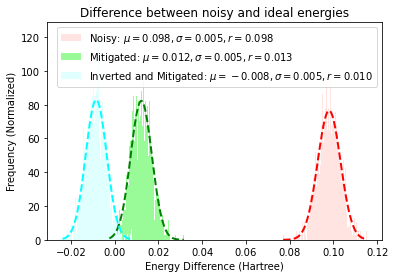

In [12]:
from Plot_Data import stats, plotter
colors = ['mistyrose', 'red', 'palegreen', 'green', 'lightcyan', 'cyan']
plotter(diff_r,diff_nr,diff_inr, colors , 'Restricted_Readout.png')

# Without Readout